<a href="https://colab.research.google.com/github/ParkEunbin/cs231n/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AlexNet**
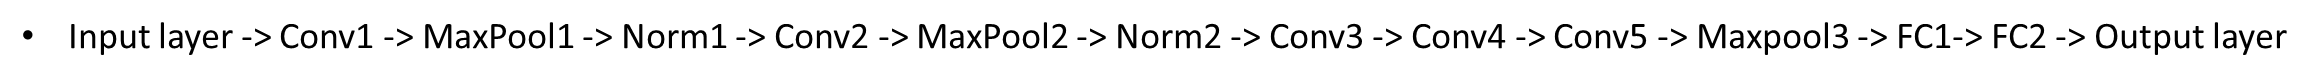

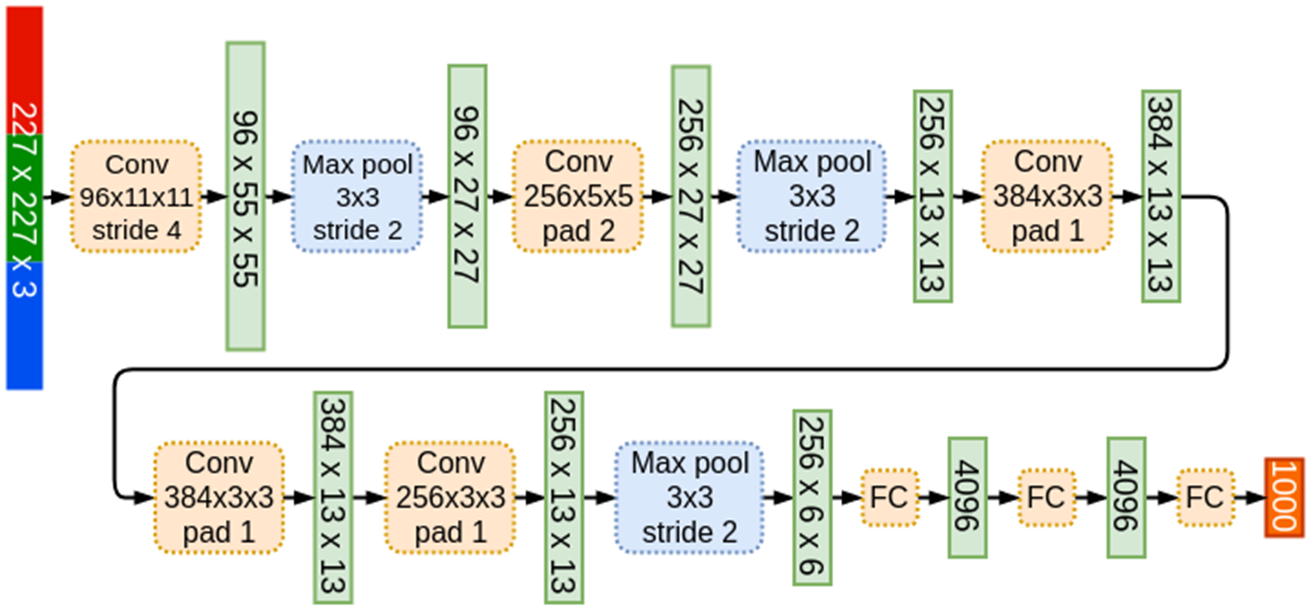

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

**1. Loading Dataset** 

* torchvision.transforms : 이미지 변환

* torchvision.dataset : dataset제공

* Dataset 은 샘플과 정답(label)을 저장하고, DataLoader 는 Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌈.

* torch.manual_seed() : 동일한 랜덤 난수 




In [3]:
#creating a dinstinct transform class for the train, validation and test dataset
#이미지 전처리 : resize, flip, 정규화
tranform_train = transforms.Compose([transforms.Resize((227,227)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((227,227)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#preparing the train, validation and test dataset
torch.manual_seed(43)
train_ds = CIFAR10("data/", train=True, download=True, transform=tranform_train) #40,000 original images + transforms
val_size = 10000 #there are 10,000 test images and since there are no transforms performed on the test, we keep the validation as 10,000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size]) #Extracting the 10,000 validation images from the train set
test_ds = CIFAR10("data/", train=False, download=True, transform=tranform_test) #10,000 images

#passing the train, val and test datasets to the dataloader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


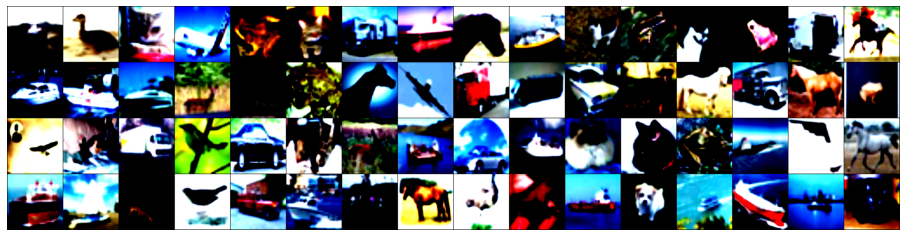

In [4]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

**2. Alexnet Model**

성능향상을 위해
* overlapping pooling을 사용 
* ReLU activation function 사용
* Data Augmentation 사용
* Dropout을 추가하면?
* Local Response Normalization (LRN) : 같은 위치의 픽셀에 대해 복수의 feature map간 정규화를 하는 방법. 

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=10)
        #self.Dropout=nn.Dropout(p=0.5, inplace=True)
        #self.LRN=nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        #x = self.LRN(x)
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        #x = self.LRN(x)
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        #x = self.Dropout(x)
        x = F.relu(self.fc1(x))
        #x = self.Dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**3. Model Preparing**

* loss :softmax
* optimizer : Adam

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda

model = AlexNet() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu

## Loss and optimizer
learning_rate = 1e-4 
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning

**4.Training**

In [7]:
for epoch in range(50): #I decided to train the model for 50 epochs
    loss_ep = 0
    
    for batch_idx, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(data)
        loss = criterion(scores,targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch} :::: {loss_ep/len(train_dl)}")

    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )

Loss in epoch 0 :::: 1.5270059611320494
Got 5497 / 10000 with accuracy 54.97
Loss in epoch 1 :::: 1.0132327676773072
Got 6733 / 10000 with accuracy 67.33
Loss in epoch 2 :::: 0.7746806722164155
Got 7354 / 10000 with accuracy 73.54
Loss in epoch 3 :::: 0.6269165408611298
Got 7701 / 10000 with accuracy 77.01
Loss in epoch 4 :::: 0.5160312148571015
Got 7926 / 10000 with accuracy 79.26


KeyboardInterrupt: ignored

**5.Save the model**

In [8]:
torch.save(model.state_dict(), "alexnet_cifar.pt") 

In [9]:
model = AlexNet()
model.load_state_dict(torch.load("/content/alexnet_cifar.pt")) #loads the trained model
model.eval()

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

**6.Testing**

In [10]:
num_correct = 0
num_samples = 0
for batch_idx, (data,targets) in enumerate(test_dl):
    data = data.to(device="cpu")
    targets = targets.to(device="cpu")
    ## Forward Pass
    scores = model(data)
    _, predictions = scores.max(1)
    num_correct += (predictions == targets).sum()
    num_samples += predictions.size(0)
print(
    f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
)

Got 7739 / 10000 with accuracy 77.39
